In [84]:
import pefile
import os
import re


import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import euclidean_distances

Obteniendo características de los malwares.

In [ ]:
ruta_carpeta = './MALWR/MALWR/'

data = {}

for nombre_archivo in os.listdir(ruta_carpeta):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    if os.path.isfile(ruta_archivo):
        pe = pefile.PE(ruta_archivo)

        # Información del PE Header
        print("Nombre del archivo: ", pe.FILE_HEADER)

        # Nombres de las secciones
        secciones = []
        for section in pe.sections:
            print(section.Name.decode().rstrip('\x00'))
            secciones.append(section.Name.decode().rstrip('\x00'))

        # Llamadas a funciones
        funciones = []
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            print('DLL: ', entry.dll.decode())
            for imp in entry.imports:
                print('\t', hex(imp.address), imp.name.decode() if imp.name else '')
                funciones.append({
                    'DLL': entry.dll.decode(),
                    'Función': imp.name.decode() if imp.name else '',
                    'Dirección': hex(imp.address)
                })

        # Cadenas de texto
        strings = list(re.findall(b"[A-Za-z0-9/\-:.,_$%'()[\]<> ]{3,}", pe.__data__))
        print('Cadenas de texto: ', strings)

        # Recursos
        recursos = []
        if hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE'):
            for resource_type in pe.DIRECTORY_ENTRY_RESOURCE.entries:
                if resource_type.name is not None:
                    print('Tipo de recurso: ', resource_type.name)
                    recursos.append(resource_type.name.decode('utf-8', 'ignore'))
                else:
                    print('Tipo de recurso: ', pefile.RESOURCE_TYPE.get(resource_type.struct.Id))
                    recursos.append(pefile.RESOURCE_TYPE.get(resource_type.struct.Id))

        # Firmas digitales
        firmas = []
        if hasattr(pe, 'VS_VERSIONINFO'):
            if hasattr(pe, 'FileInfo'):
                for fileinfo in pe.FileInfo:
                    if hasattr(fileinfo, 'StringTable'):
                        for st in fileinfo.StringTable:
                            for entry in st.entries.items():
                                print(entry)
                                firmas.append(entry)

        # Almacenando la información en un diccionario.
        data[nombre_archivo] = {
            'Secciones': secciones,
            'Funciones': funciones,
            'Cadenas de texto': strings,
            'Recursos': recursos,
            'Firmas digitales': firmas
        }

df = pd.DataFrame.from_dict(data, orient='index')

df.insert(0, 'Nombre', df.index)

# Eliminando la primera columna
df = df.reset_index(drop=True)

df.to_csv('malwr.csv', index=False)

Analizando y preprocesando el dataset

In [57]:
df = pd.read_csv('malwr.csv')

# Convertiendo las cadenas de texto a listas y diccionarios
for col in ['Secciones', 'Funciones', 'Cadenas de texto', 'Recursos', 'Firmas digitales']:
    df[col] = df[col].apply(ast.literal_eval)

# Transformar las listas en vectores de características
mlb = MultiLabelBinarizer()
for col in ['Secciones', 'Recursos']:
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop(col)),
                              columns=mlb.classes_,
                              index=df.index))

# Extrayendo solo los nombres de las funciones
df['Funciones'] = df['Funciones'].apply(lambda x: [func['Función'] for func in x])

# Transformando las listas de funciones en vectores de características
mlb = MultiLabelBinarizer()
df_funciones = pd.DataFrame(mlb.fit_transform(df.pop('Funciones')),
                            columns=mlb.classes_,
                            index=df.index)
df = df.join(df_funciones.add_prefix('Función_'))

# Convertiendo las listas de cadenas de texto a cadenas de texto
df['Cadenas de texto'] = df['Cadenas de texto'].apply(lambda x: ' '.join([s.decode('utf-8', 'ignore') for s in x]))

# Vectorizando las cadenas de texto
vectorizer = TfidfVectorizer(max_features=1000)
df_cadenas = pd.DataFrame(vectorizer.fit_transform(df.pop('Cadenas de texto')).toarray(),
                          columns=vectorizer.get_feature_names_out(),
                          index=df.index)

df = df.join(df_cadenas.add_prefix('Texto_'))



if 'Firmas digitales' in df.columns:
    df = df.drop('Firmas digitales', axis=1)

# Guardando el conjunto de datos
df.to_csv('malwr_data.csv', index=False)

Aplicando algoritmos

In [79]:
df = pd.read_csv('malwr_data.csv')

# Eliminando la columna 'Nombre' ya que no es una característica
X = df.drop('Nombre', axis=1)

Algoritmo de KMeans

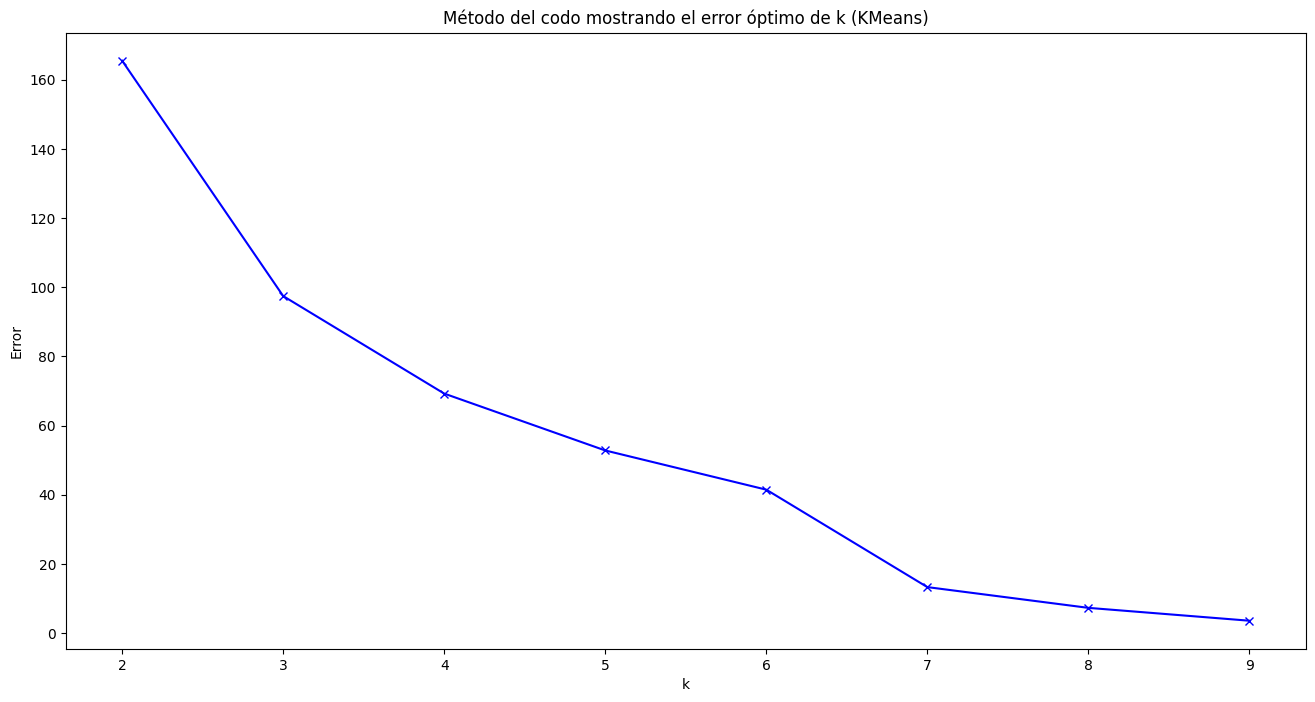

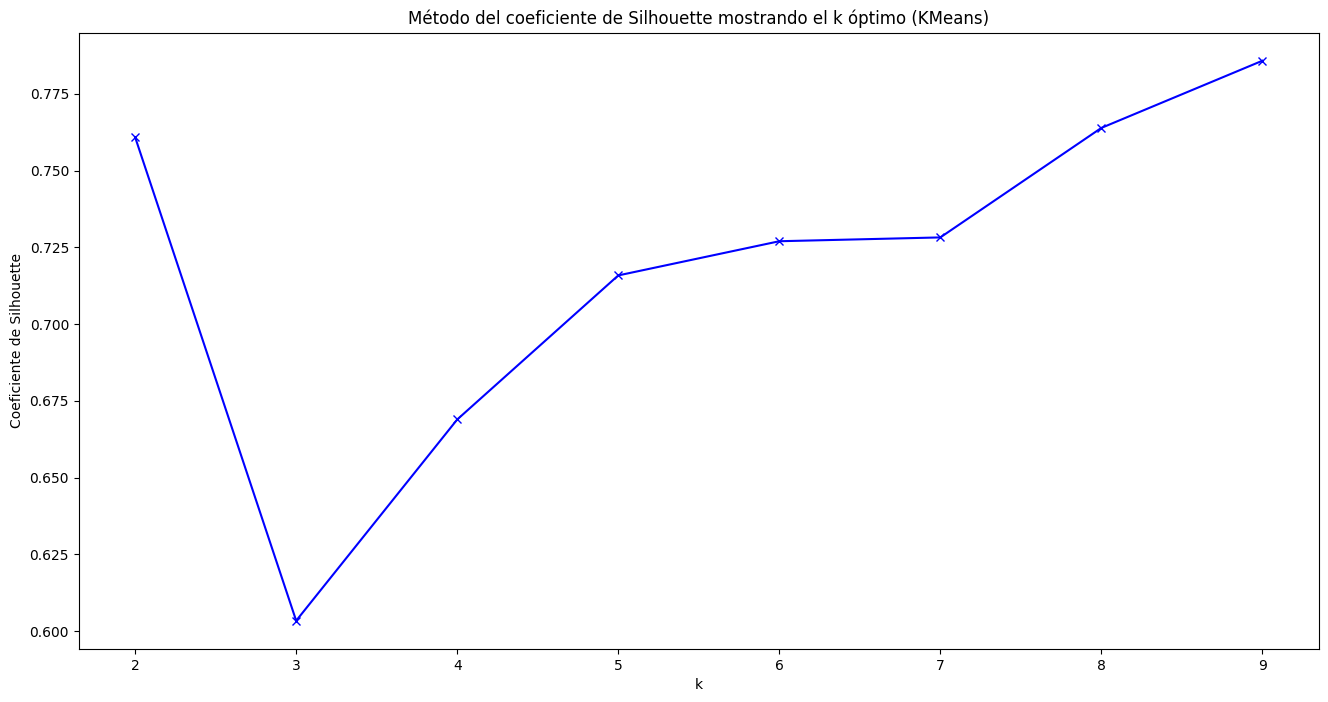

In [81]:
# Lista para almacenar los errores de cada valor de K
errores_kmeans = []
silhouettes_kmeans = []

# Rango de valores de K que quieres probar
K = range(2, 10)

for k in K:
    # Creando un modelo KMeans con k clústeres
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # Calculando el error cuadrático medio del modelo KMeans
    error = kmeans.inertia_
    errores_kmeans.append(error)
    
    # Etiquetando cada observación según el clúster indicado por KMeans
    df['Etiqueta_KMeans'] = kmeans.labels_
    _
    # Calculando el coeficiente de Silhouette del modelo KMeans
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouettes_kmeans.append(silhouette)

# Graficando el método del código
plt.figure(figsize=(16,8))
plt.plot(K, errores_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Error')
plt.title('Método del codo mostrando el error óptimo de k (KMeans)')
plt.show()

# Graficando el coeficiente de Silhouette contra K
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (KMeans)')
plt.show()

Reductor de dimensionalidad de los datos analizados

In [ ]:
# Reduciendo la dimensionalidad a 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

Gráfico de dispersión de KMeans

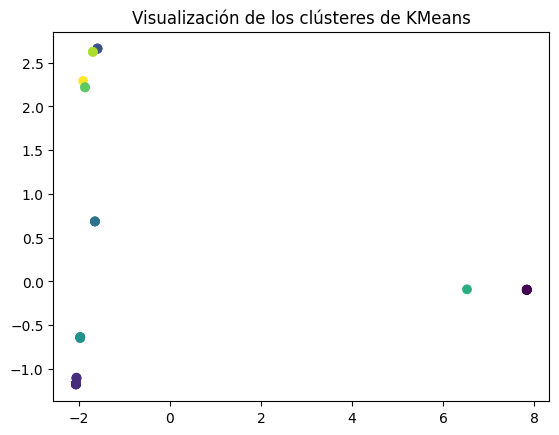

In [72]:
# Creando un gráfico de dispersión de las etiquetas de clúster de KMeans
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_KMeans'])
plt.title('Visualización de los clústeres de KMeans')
plt.show()

Método de AgglomerativeClustering

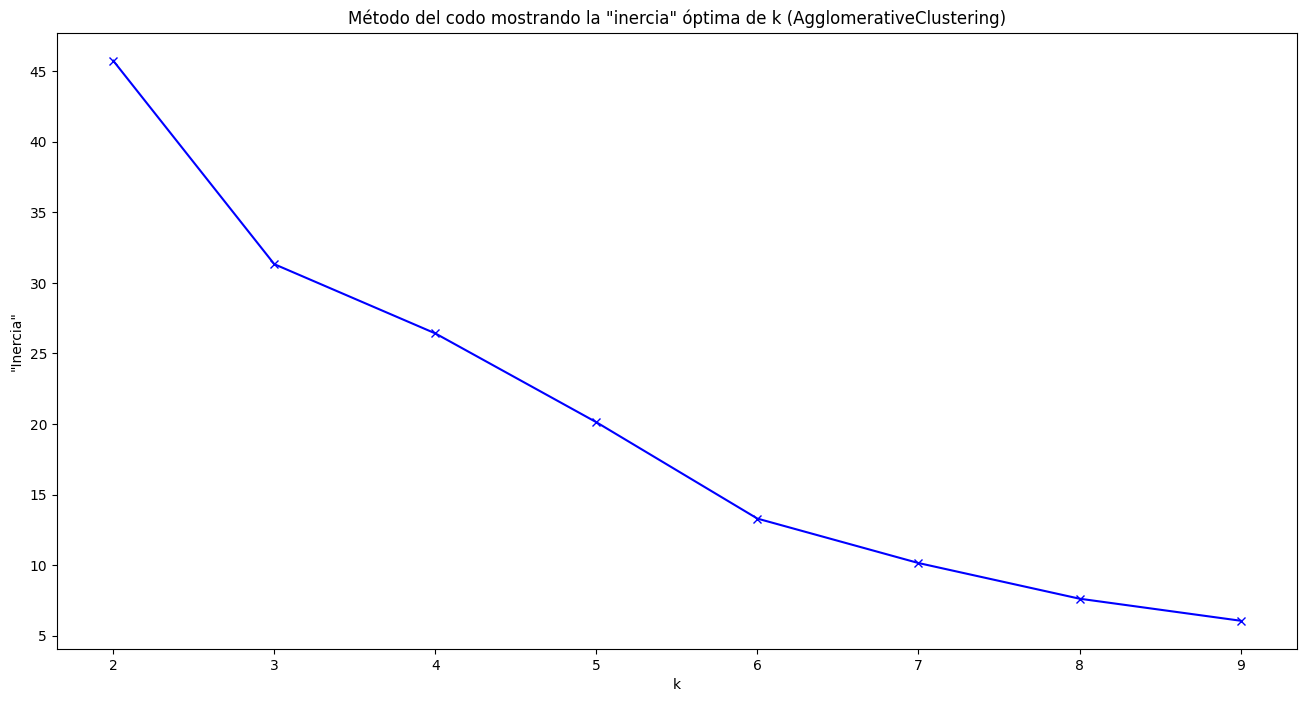

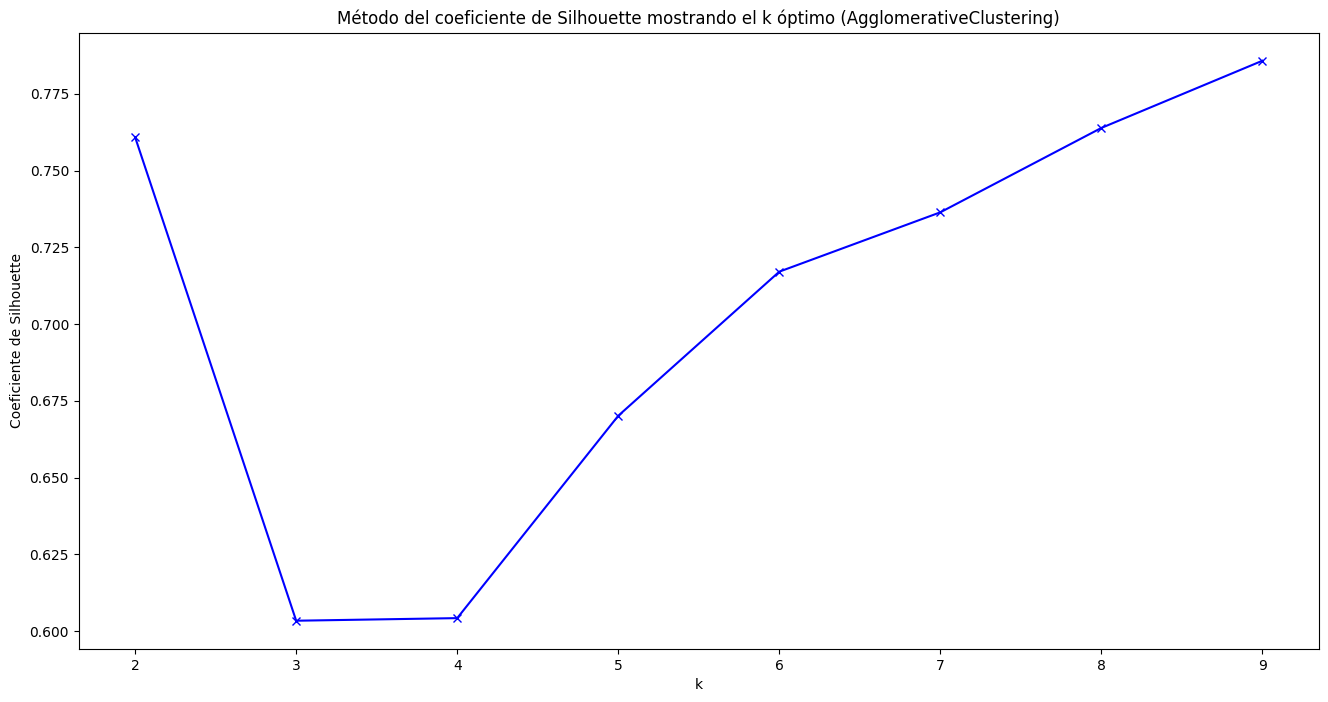

In [85]:
# Lista para almacenar las inercias de cada valor de K
inercias_agglo = []
silhouettes_agglo = []

for k in K:
    # Creando un modelo AgglomerativeClustering con k clústeres
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(X)
    
    # Calculando la "inercia" del modelo AgglomerativeClustering
    inercia = 0
    for cluster_id in range(k):
        cluster_samples = X[labels == cluster_id]
        if len(cluster_samples) > 1:
            dist_matrix = euclidean_distances(cluster_samples)
            inercia += dist_matrix.sum() / (2 * len(cluster_samples))
    inercias_agglo.append(inercia)
    
    # Calculando el coeficiente de Silhouette del modelo AgglomerativeClustering
    silhouette = silhouette_score(X, labels)
    silhouettes_agglo.append(silhouette)
    
    # Etiquetando cada observación según el clúster indicado por AgglomerativeClustering
    df['Etiqueta_Agglo'] = labels

# Graficando la "inercia" contra K
plt.figure(figsize=(16,8))
plt.plot(K, inercias_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('"Inercia"')
plt.title('Método del codo mostrando la "inercia" óptima de k (AgglomerativeClustering)')
plt.show()

# Graficando el coeficiente de Silhouette contra K
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (AgglomerativeClustering)')
plt.show()

Gráfico de dispersión de AgglomerativeClustering

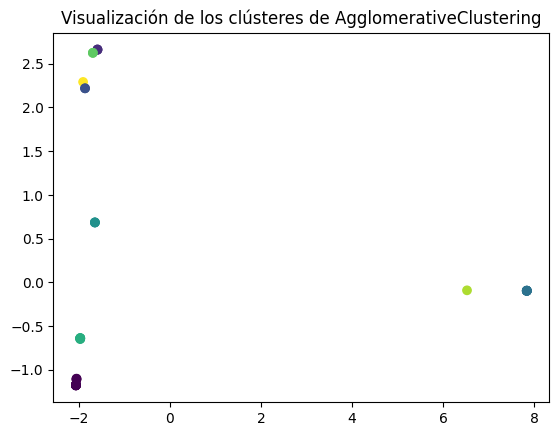

In [78]:
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_Agglo'])
plt.title('Visualización de los clústeres de AgglomerativeClustering')
plt.show()